# Running our full inference pipeline, for the scientific papers dataset. Paths can be directly substituted to reproduce results for the news articles dataset.

### Functions for running the "prediction aggregation" methods. These functions include selecting the "k' hyperparameter and then using it to extract the F1 score.

In [1]:

from matching_metrics import get_macro_f1
import pandas as pd
from data_refining_pipeline import get_embed_votes_and_f1
import random
from sklearn.metrics.pairwise import cosine_similarity
import tqdm
from data_refining_pipeline import alg_for_par_selection,get_embed_votes_and_f1, alg_for_par_selection_with_initial_cents, train_df_to_centroids_v2
import random
from time import time
import numpy as np
from sklearn.metrics import silhouette_score
ks = range(1, 20)

def extract_best_k_for_both_approaches(no_val_model, train_set_no_val, val_set, prefix, ks, model_name):
    cents, cent_d =train_df_to_centroids_v2(train_set_no_val, f'abstract_{model_name}_embedding')
    train_set_no_val = alg_for_par_selection(train_set_no_val, cents, f'abstract_{model_name}_embedding', f'pars_{model_name}_embedding', 'pars', verbose=False)
    post_alg_cents, post_alg_cent_d = train_df_to_centroids_v2(train_set_no_val, 'closest_par')
    conf_f1s, cert_f1s, first_f1s = [], [], []
    for k in tqdm(ks):
        conf_f1s.append(get_embed_votes_and_f1(val_set, f'pars_{model_name}_embedding', post_alg_cents, 'highest_confidence', k)[1])
        cert_f1s.append(get_embed_votes_and_f1(val_set, f'pars_{model_name}_embedding', post_alg_cents, 'highest_certainty', k)[1])
        first_f1s.append(get_embed_votes_and_f1(val_set, f'pars_{model_name}_embedding', post_alg_cents, 'first', k)[1])
        
    best_conf_k = ks[np.argmax(conf_f1s)]
    best_cert_k = ks[np.argmax(cert_f1s)]
    best_first_k = ks[np.argmax(first_f1s)]
    print(f"Best k for highest confidence: {best_conf_k}, F1: {max(conf_f1s)}")
    print(f"Best k for highest certainty: {best_cert_k}, F1: {max(cert_f1s)}")
    print(f"Best k for first: {best_first_k}, F1: {max(first_f1s)}")
    return {
        'highest_confidence': best_conf_k,
        'highest_certainty': best_cert_k,
        'first': best_first_k}

def best_ks_to_get_final_f1_and_sil(full_model, full_train_set, test_set, k_dict, prefix, model_name, with_LLM=True):
    cat_to_idx = {k: i for i, k in enumerate(full_train_set['category'].unique())}
    test_set['cat_id'] = test_set['category'].apply(lambda x: cat_to_idx[x])

    cents, cent_d =train_df_to_centroids_v2(full_train_set, f'abstract_{model_name}_embedding')
    full_train_set = alg_for_par_selection(full_train_set, cents, f'abstract_{model_name}_embedding', f'pars_{model_name}_embedding', 'pars', verbose=False)
    post_alg_cents, post_alg_cent_d = train_df_to_centroids_v2(full_train_set, 'closest_par')
    f1_d = {}
    sil_d = {}
    sil_d['abstract representation'] = silhouette_score(test_set[f'abstract_{model_name}_embedding'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')
    if with_LLM:
        sil_d['LLM summary representation'] = silhouette_score(test_set[f'LLM_summ_{model_name}_embedding'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')
        test_set['LLM_pred'] = test_set[f'LLM_summ_{model_name}_embedding'].apply(lambda x: np.argmax(cosine_similarity([x], post_alg_cents)[0]))
    test_set['abstract_pred'] = test_set[f'abstract_{model_name}_embedding'].apply(lambda x: np.argmax(cosine_similarity([x], post_alg_cents)[0]))

    if with_LLM:
        test_pairs = pd.merge(test_set[['id','cat_id','category', 'LLM_pred','abstract_pred']], test_set[['id','cat_id','category', 'LLM_pred','abstract_pred']], how='cross', suffixes=('_1', '_2'))
        test_pairs['LLM_pred'] = test_pairs.apply(lambda x: 1 if x['LLM_pred_1'] == x['LLM_pred_2'] else 0, axis=1)
    else:
        test_pairs = pd.merge(test_set[['id','cat_id','category','abstract_pred']], test_set[['id','cat_id','category','abstract_pred']], how='cross', suffixes=('_1', '_2'))
    test_pairs['abstract_pred'] = test_pairs.apply(lambda x: 1 if x['abstract_pred_1'] == x['abstract_pred_2'] else 0, axis=1)
    test_pairs['label'] = test_pairs.apply(lambda x: 1 if x['cat_id_1'] == x['cat_id_2'] else 0, axis=1)
    
    if with_LLM:
        f1_d['LLM summary'] = get_macro_f1(test_pairs, pred_col_name='LLM_pred')[0]
    f1_d['abstract'] = get_macro_f1(test_pairs, pred_col_name='abstract_pred')[0]
    for selection_mode, k_val in k_dict.items():
        print(f"Running selection mode: {selection_mode} with k={k_val}")
        sel_t = time()
        test_set, f1_val = get_embed_votes_and_f1(test_set, f'pars_{model_name}_embedding', post_alg_cents, selection_mode, k_val)
        f1_d[selection_mode] = f1_val
        test_set['agreeing_with_vote'] = test_set.apply(lambda x: [i for i, _ in enumerate(x['arg_highest_and_highest_per_par'][0])
                                                                   if x['arg_highest_and_highest_per_par'][0][i] == x['top_k_winner']], axis=1)
        rand_sils = []
        for _ in tqdm(range(1000)):
            test_set['rand_agreeing_par'] = test_set['agreeing_with_vote'].apply(lambda x: random.sample(x,1)[0] if len(x) > 0 else 1)
            test_set['rand_rep'] = test_set.apply(lambda x: x[f'pars_{model_name}_embedding'][x['rand_agreeing_par']], axis=1)
            rand_sils.append(silhouette_score(test_set['rand_rep'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine'))
        sil_d[f'random {selection_mode}'] = f"{round(float(np.mean(rand_sils)),3)}+- {round(float(np.std(rand_sils)),3)}"
        pre_alg_t = time()
        test_set = alg_for_par_selection_with_initial_cents(test_set, post_alg_cents, 'top_k_winner', f'pars_{model_name}_embedding', 'pars', verbose=True)
        post_alg_t = time()
        sil_d[f'{selection_mode} alg selection'] = silhouette_score(test_set['closest_par'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')
    return f1_d, sil_d




### Creating embeddings for both models

In [ ]:
from loading_paper_utils import load_data_from_pkl, embed_col, embed_text_list_col
from sentence_transformers import SentenceTransformer
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Set to the GPU you want to use, e.g., "0" for the first GPU

full_train_set = load_data_from_pkl('FULL/TRAIN/SET/PKL/PATH')
train_set_no_val = load_data_from_pkl('TRAIN/SET/WITHOUT/VAL/PKL/PATH')
test_set = load_data_from_pkl('TEST/SET/PKL/PATH')
val_set = load_data_from_pkl('VAL/SET/PKL/PATH')
for df in (full_train_set, train_set_no_val, test_set, val_set):
    df['pars'] = df.apply(lambda x: [x['title']] + [x['abstract']] + x['pars'], axis=1)
mpnet_trained_with_validation = SentenceTransformer('MPNET/MODEL/TRAINED/ON/FULL/TRAIN/SET/PATH')
mpnet_trained_without_validation = SentenceTransformer('MPNET/MODEL/TRAINED/ON/TRAIN/SET/WITHOUT/VAL/PATH')
e5_trained_without_validation = SentenceTransformer('E5/MODEL/TRAINED/ON/TRAIN/SET/WITHOUT/VAL/PATH')
e5_trained_with_validation = SentenceTransformer('E5/MODEL/TRAINED/ON/FULL/TRAIN/SET/PATH')

for df in [train_set_no_val, val_set]:
    for model, model_name in [(mpnet_trained_without_validation, 'mpnet'), (e5_trained_without_validation, 'e5')]:
        embed_text_list_col(df, model, 'pars', model_name, 'query: ' if 'e5' in model_name else '', normalize=True)
        embed_col(df, model, 'abstract', model_name=model_name, prefix='query: ' if 'e5' in model_name else '', normalize=True)
for df in [full_train_set, test_set]:
    for model, model_name in [(mpnet_trained_with_validation, 'mpnet'), (e5_trained_with_validation, 'e5')]:
        embed_text_list_col(df, model, 'pars', model_name, 'query: ' if 'e5' in model_name else '', normalize=True)
        embed_col(df, model, 'abstract', model_name=model_name, prefix='query: ' if 'e5' in model_name else '', normalize=True)
for model, model_name in [(mpnet_trained_with_validation, 'mpnet'), (e5_trained_with_validation, 'e5')]:
    embed_col(test_set, model, 'LLM_summ', model_name=model_name, prefix='query: ' if 'e5' in model_name else '', normalize=True)

Embedding pars:   4%|▎         | 26/737 [00:02<01:10, 10.02it/s]

100%|██████████| 5/5 [00:00<00:00, 10.19it/s]


### Checking silhouette score for train set

In [3]:
from sklearn.metrics import silhouette_score
news_cat_d = {cat:i for i, cat in enumerate(full_train_set['category'].unique())}
full_train_set['cat_id'] = full_train_set['category'].apply(lambda x: news_cat_d[x])
print(silhouette_score(full_train_set['abstract_e5_embedding'].tolist(), full_train_set['cat_id'].tolist(), metric='cosine'))
print(silhouette_score(full_train_set['abstract_mpnet_embedding'].tolist(), full_train_set['cat_id'].tolist(), metric='cosine'))

0.9217128
0.9226519


### Silhouette improvement results

Centroids shape: (16, 768)


  6%|▌         | 6/100 [00:02<00:36,  2.57it/s]

Converged after 6 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [0.9421602, 0.94269377, 0.9427497, 0.94276816, 0.94277966, 0.942785, 0.9427865]
Centroids shape: (16, 768)



  4%|▍         | 4/100 [00:00<00:07, 13.05it/s]


Converged after 4 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [26.30490250985825, 26.56720295514749, 26.5952402333522, 26.601366208650976, 26.60321947279423]


  3%|▎         | 3/100 [00:00<00:07, 12.27it/s]


Converged after 3 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [21.066772141762844, 21.207579370339953, 21.223459911593885, 21.223706078275164]


  5%|▌         | 5/100 [00:00<00:06, 13.71it/s]


Converged after 5 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [26.040405159779144, 26.231455864522292, 26.410112798171355, 26.409586926380687, 26.411850239509242, 26.425381389806383]
Centroids shape: (16, 768)


  8%|▊         | 8/100 [00:03<00:41,  2.22it/s]

Converged after 8 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [0.9439055, 0.94448924, 0.9445731, 0.944603, 0.94461834, 0.9446306, 0.94463694, 0.9446395, 0.9446404]
Centroids shape: (16, 768)



  3%|▎         | 3/100 [00:00<00:11,  8.32it/s]


Converged after 3 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [22.790056366464437, 23.00298089963788, 23.040615498450308, 23.11930554562125]


  3%|▎         | 3/100 [00:00<00:11,  8.43it/s]


Converged after 3 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [23.189249872741957, 23.41138390800192, 23.44950195520862, 23.460157138738506]


  3%|▎         | 3/100 [00:00<00:11,  8.36it/s]


Converged after 3 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [26.83048107169642, 27.196486183514534, 27.310400301957213, 27.322259364276977]
E5
           pre alg  post alg
abstract  0.455200  0.488889
mean      0.365019  0.400309
LLM       0.435288  0.486060


MPNet
           pre alg  post alg
abstract  0.448524  0.457624
mean      0.409436  0.444564
LLM       0.464613  0.506376


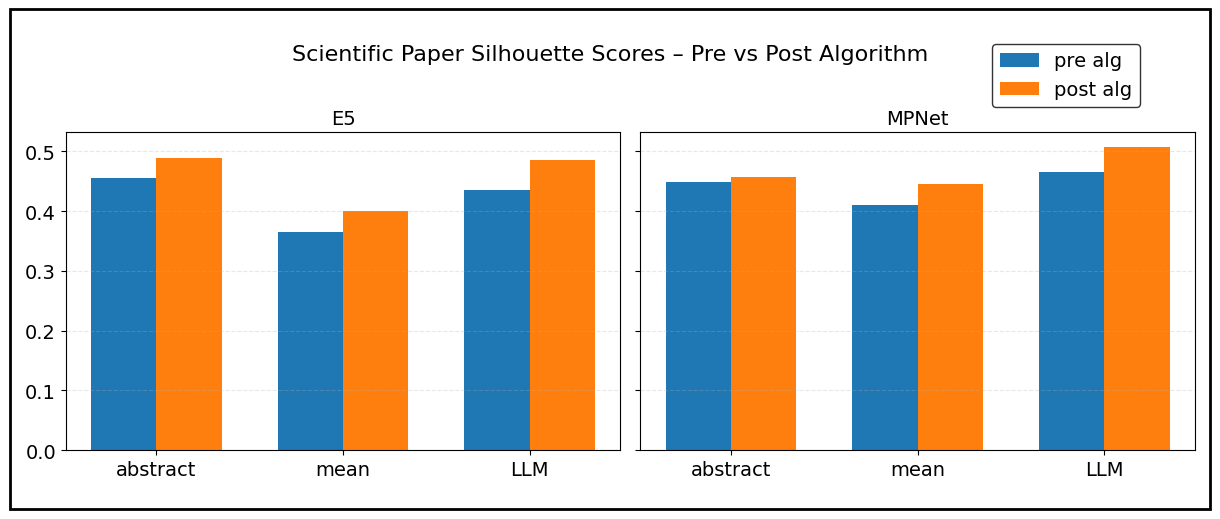

In [ ]:
import pickle
from sklearn.metrics import silhouette_score
from data_refining_pipeline import alg_for_par_selection, alg_for_par_selection_with_initial_cents, train_df_to_centroids_v2
cat_to_idx = {k: i for i, k in enumerate(full_train_set['category'].unique())}
test_set['mean_e5_embedding'] = test_set['pars_e5_embedding'].apply(lambda x: np.mean(x, axis=0))
test_set['mean_mpnet_embedding'] = test_set['pars_mpnet_embedding'].apply(lambda x: np.mean(x, axis=0))
e5_abs_rep = test_set['abstract_e5_embedding'].tolist()
e5_LLM_rep = test_set['LLM_summ_e5_embedding'].tolist()
e5_mean_rep = test_set['mean_e5_embedding'].tolist()

e5_LLM_sil = silhouette_score(test_set['LLM_summ_e5_embedding'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')
mpnet_LLM_sil = silhouette_score(test_set['LLM_summ_mpnet_embedding'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')
e5_mean_sil = silhouette_score(np.array(test_set['mean_e5_embedding'].tolist()), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')
mpnet_mean_sil = silhouette_score(np.array(test_set['mean_mpnet_embedding'].tolist()), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')
e5_abs_sil = silhouette_score(test_set['abstract_e5_embedding'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')
mpnet_abs_sil = silhouette_score(test_set['abstract_mpnet_embedding'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')


#ALG shaninigans E5
e5_cents, e5_cent_d = train_df_to_centroids_v2(full_train_set, 'abstract_e5_embedding')
full_train_set = alg_for_par_selection(full_train_set, e5_cents, 'abstract_e5_embedding', 'pars_e5_embedding')
post_alg_e5_cents, post_alg_e5_cent_d = train_df_to_centroids_v2(full_train_set, 'closest_par')
test_set['e5_abstract_pred'] = test_set['abstract_e5_embedding'].apply(lambda x: np.argmax(cosine_similarity([x], post_alg_e5_cents)[0]))
test_set = alg_for_par_selection_with_initial_cents(test_set, post_alg_e5_cents, 'e5_abstract_pred', 'pars_e5_embedding')
e5_post_alg_sil = silhouette_score(test_set['closest_par'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')
e5_post_alg_abs_rep = test_set['closest_par'].tolist()

test_set['mean_e5_pred'] = test_set['mean_e5_embedding'].apply(lambda x: np.argmax(cosine_similarity([x], post_alg_e5_cents)[0]))
test_set = alg_for_par_selection_with_initial_cents(test_set, post_alg_e5_cents, 'mean_e5_pred', 'pars_e5_embedding')
mean_e5_post_alg_sil = silhouette_score(test_set['closest_par'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')
e5_post_alg_mean_rep = test_set['closest_par'].tolist()

test_set['e5_LLM_pred'] = test_set['LLM_summ_e5_embedding'].apply(lambda x: np.argmax(cosine_similarity([x], post_alg_e5_cents)[0]))
test_set = alg_for_par_selection_with_initial_cents(test_set, post_alg_e5_cents, 'e5_LLM_pred', 'pars_e5_embedding')
LLM_e5_post_alg_sil = silhouette_score(test_set['closest_par'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')
e5_post_alg_LLM_rep = test_set['closest_par'].tolist()
# ALG shaninigans MPNet
mpnet_cents, mpnet_cent_d = train_df_to_centroids_v2(full_train_set, 'abstract_mpnet_embedding')
full_train_set = alg_for_par_selection(full_train_set, mpnet_cents, 'abstract_mpnet_embedding', 'pars_mpnet_embedding')
post_alg_mpnet_cents, post_alg_mpnet_cent_d = train_df_to_centroids_v2(full_train_set, 'closest_par')
test_set['mpnet_abstract_pred'] = test_set['abstract_mpnet_embedding'].apply(lambda x: np.argmax(cosine_similarity([x], post_alg_mpnet_cents)[0]))
test_set = alg_for_par_selection_with_initial_cents(test_set, post_alg_mpnet_cents, 'mpnet_abstract_pred', 'pars_mpnet_embedding')
mpnet_post_alg_sil = silhouette_score(test_set['closest_par'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')

test_set['mean_mpnet_pred'] = test_set['mean_mpnet_embedding'].apply(lambda x: np.argmax(cosine_similarity([x], post_alg_mpnet_cents)[0]))
test_set = alg_for_par_selection_with_initial_cents(test_set, post_alg_mpnet_cents, 'mean_mpnet_pred', 'pars_mpnet_embedding')
mean_mpnet_post_alg_sil = silhouette_score(test_set['closest_par'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')

test_set['mpnet_LLM_pred'] = test_set['LLM_summ_mpnet_embedding'].apply(lambda x: np.argmax(cosine_similarity([x], post_alg_mpnet_cents)[0]))
test_set = alg_for_par_selection_with_initial_cents(test_set, post_alg_mpnet_cents, 'mpnet_LLM_pred', 'pars_mpnet_embedding')
LLM_mpnet_post_alg_sil = silhouette_score(test_set['closest_par'].tolist(), test_set['category'].apply(lambda x: cat_to_idx[x]).tolist(), metric='cosine')

e5_res_d = {'pre alg': {}, 'post alg': {}}
e5_res_d['pre alg']['abstract'] = e5_abs_sil
e5_res_d['pre alg']['mean'] = e5_mean_sil
e5_res_d['pre alg']['LLM'] = e5_LLM_sil
e5_res_d['post alg']['abstract'] = e5_post_alg_sil
e5_res_d['post alg']['mean'] = mean_e5_post_alg_sil
e5_res_d['post alg']['LLM'] = LLM_e5_post_alg_sil

mpnet_res_d = {'pre alg': {}, 'post alg': {}}
mpnet_res_d['pre alg']['abstract'] = mpnet_abs_sil
mpnet_res_d['pre alg']['mean'] = mpnet_mean_sil
mpnet_res_d['pre alg']['LLM'] = mpnet_LLM_sil
mpnet_res_d['post alg']['abstract'] = mpnet_post_alg_sil
mpnet_res_d['post alg']['mean'] = mean_mpnet_post_alg_sil
mpnet_res_d['post alg']['LLM'] = LLM_mpnet_post_alg_sil

print('E5')
print(pd.DataFrame(e5_res_d))
print('\n')
print('MPNet')
print(pd.DataFrame(mpnet_res_d))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_grouped_subplots(e5_res_d, mpnet_res_d, suptitle="Pre vs Post Algorithm Comparison"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    def plot_one(ax, res_d, title):
        categories = list(res_d['pre alg'].keys())
        pre_vals = [res_d['pre alg'][k] for k in categories]
        post_vals = [res_d['post alg'][k] for k in categories]

        x = np.arange(len(categories))
        width = 0.35

        bars1 = ax.bar(x - width/2, pre_vals,  width, label='pre alg')
        bars2 = ax.bar(x + width/2, post_vals, width, label='post alg')

        ax.set_xticks(x)
        ax.set_xticklabels(categories, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        return bars1, bars2

    bars1, bars2 = plot_one(axes[0], e5_res_d,    "E5")
    plot_one(axes[1], mpnet_res_d, "MPNet")

    # Single legend in the upper right corner of the figure
    fig.legend([bars1, bars2], ['pre alg', 'post alg'],
               loc='upper right', bbox_to_anchor=(0.95, 0.95),
               frameon=True, edgecolor='black', fontsize=14)
    fig.patches.append(Rectangle(
        (0, 0), 1, 1, transform=fig.transFigure,
        fill=False, color='black', linewidth=2
    ))

    fig.suptitle(suptitle, fontsize=16, y=0.93)
    fig.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()
    with open('RES/FIG/SAVE/PATH', 'wb') as f:
        pickle.dump(fig, f)


# Example usage
plot_grouped_subplots(e5_res_d, mpnet_res_d, suptitle="Scientific Paper Silhouette Scores – Pre vs Post Algorithm")


### Heterogeneity results

0.31339700913594093


<Axes: >

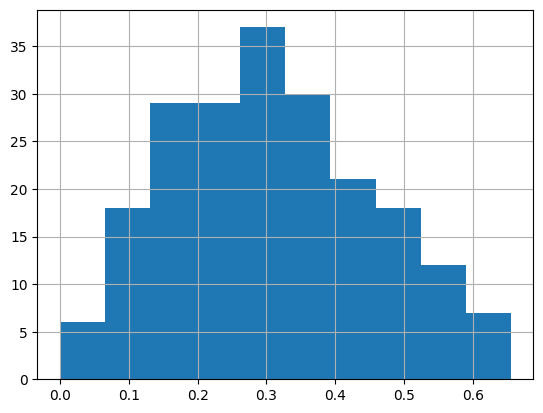

In [13]:
from scipy.stats import entropy
for cent_name, cents in [('e5', post_alg_e5_cents), ('mpnet', post_alg_mpnet_cents)]:
    test_set[f'{cent_name}_preds'] = test_set[f'pars_{cent_name}_embedding'].apply(lambda x: np.argmax(cosine_similarity(x, cents), axis=1))
    test_set[f'{cent_name}_hist'] = test_set[f'{cent_name}_preds'].apply(lambda x: [np.sum(x == i) for i in range(len(cents))])
    test_set[f'{cent_name}_dist'] = test_set[f'{cent_name}_hist'].apply(lambda x: np.array(x) / np.sum(x) if np.sum(x) > 0 else np.array(x))
    test_set[f'{cent_name}_dist'] = test_set[f'{cent_name}_dist'].apply(lambda x: (x + 1e-10) / np.sum(x + 1e-10))  # smoothing to avoid zero probs
    test_set[f'{cent_name}_entropy'] = test_set[f'{cent_name}_dist'].apply(lambda x: entropy(x) / np.log(len(cents)))
    test_set[f'{cent_name}_pred_set'] = test_set[f'{cent_name}_preds'].apply(lambda x: set(x))
    test_set[f'{cent_name}_pred_set_size'] = test_set[f'{cent_name}_pred_set'].apply(lambda x: len(x) / len(post_alg_e5_cents))
sci_res_d = {}
for model_name in ['e5', 'mpnet']:
    sci_res_d[model_name] = {}
    for cat in test_set['category'].unique():
        cat_df = test_set[test_set['category'] == cat]
        sci_res_d[model_name][cat] = np.mean(cat_df[f'{model_name}_entropy'])
    sci_res_d[model_name]['total'] = np.mean(list(sci_res_d[model_name].values()))
# pd.DataFrame(sci_res_d)
print(sci_res_d['e5']['total'])
test_set['e5_entropy'].hist()

### Downstream application results (simulation)

### E5

In [ ]:
from matching_metrics import get_macro_f1
from joblib import Parallel, delayed
import os

# Fix for Hugging Face tokenizers warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def get_recall_prec_at_k(vec_list, cat_list, k):
    sims = cosine_similarity(vec_list)
    cat_hist = {}
    for item in cat_list:
        cat_hist[item] = cat_hist.get(item, 0) + 1
    sims = np.argsort(sims, axis=1)[:, ::-1][:, 1:]  # Exclude self
    cat_vals = set(cat_list)
    rec_d = {cat: [] for cat in cat_vals}
    prec_d = {cat: [] for cat in cat_vals}
    for i, idx_vec in enumerate(sims):
        correct_cat = cat_list[i]
        rec_d[correct_cat].append(sum([1 for idx in idx_vec[:k] if cat_list[idx] == correct_cat]) / cat_hist[correct_cat])
        prec_d[correct_cat].append(sum([1 for idx in idx_vec[:k] if cat_list[idx] == correct_cat]) / min(k, cat_hist[correct_cat]))
    rec_at_k = {cat: np.mean(rec_d[cat]) for cat in cat_vals}
    prec_at_k = {cat: np.mean(prec_d[cat]) for cat in cat_vals}
    return np.mean(list(rec_at_k.values())), np.mean(list(prec_at_k.values()))



def simulate_single_iteration(p, test_set_copy, cat_l, post_alg_cents):
    """Single iteration simulation function for parallel processing"""
    
    # Create a copy to avoid modifying the original
    test_set_iter = test_set_copy.copy()
    def remove_val_and_return(item_list, val):
        new_list = item_list.copy()
        new_list.remove(val)
        return new_list
    # Apply probabilistic category selection
    test_set_iter['predicted_cat_idx'] = test_set_iter['correct_cat_idx'].apply(
        lambda x: x if np.random.rand() < p else np.random.choice(remove_val_and_return(cat_l, x))
    )
    
    # Run algorithm
    post_alg_test_set = alg_for_par_selection_with_initial_cents(
        test_set_iter, post_alg_cents, 'predicted_cat_idx', 'pars_e5_embedding', verbose=False
    )
    post_alg_test_set.reset_index(drop=True, inplace=True)
    
    # Calculate silhouette score
    sil_score = silhouette_score(
        post_alg_test_set['closest_par'].tolist(), 
        post_alg_test_set['predicted_cat_idx'].tolist(), 
        metric='cosine'
    )
    
    
    # Calculate recall@k for different k values
    closest_pars = post_alg_test_set['closest_par'].tolist()
    correct_cats = post_alg_test_set['correct_cat_idx'].tolist()
    
    recall_scores = {}
    precision_scores = {}
    for k in [1, 3, 5, 10]:
        rec, prec = get_recall_prec_at_k(closest_pars, correct_cats, k)
        recall_scores[k] = rec
        precision_scores[k] = prec
    
    # return sil_score, f1_score, recall_scores, precision_scores
    return sil_score, recall_scores, precision_scores

# Prepare data
cat_d = {cat: i for i, cat in enumerate(test_set['category'].unique())}
cat_list = list(cat_d.values())
test_set['correct_cat_idx'] = test_set['category'].apply(lambda x: cat_d[x])

# Initialize result containers
sils = []
f1s = []
rec_at_k_d = {1: [], 3: [], 5: [], 10: []}
prec_at_k_d = {1: [], 3: [], 5: [], 10: []}
p_vals = np.arange(0.1, 1.1, 0.1)

# Determine number of jobs (use -1 for all available cores, or specify a number)
n_jobs = -1
print(f"Using joblib with {n_jobs} jobs for parallelization")

# Run simulations for each p value
for p in tqdm(p_vals, desc="Processing p values"):
    print(f"Processing p={p:.2f}")
    
    # Run parallel simulations using joblib
    results = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(simulate_single_iteration)(p, test_set, cat_list, post_alg_e5_cents)
        for _ in range(500)
    )
    
    # Extract and aggregate results
    sils_for_avg = [result[0] for result in results]
    # f1s_for_avg = [result[1] for result in results]
    recs_for_avg = {k: [result[1][k] for result in results] for k in [1, 3, 5, 10]}
    precs_for_avg = {k: [result[2][k] for result in results] for k in [1, 3, 5, 10]}
    
    # Store averaged results
    sils.append(np.mean(sils_for_avg))
    # f1s.append(np.mean(f1s_for_avg))
    for k in rec_at_k_d.keys():
        rec_at_k_d[k].append(np.mean(recs_for_avg[k]))
        prec_at_k_d[k].append(np.mean(precs_for_avg[k]))



Using joblib with -1 jobs for parallelization


Processing p values:   0%|          | 0/10 [00:00<?, ?it/s]

Processing p=0.10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished
Processing p values:  10%|█         | 1/10 [01:26<13:02, 86.91s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.20


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  20%|██        | 2/10 [02:54<11:37, 87.22s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.30


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  30%|███       | 3/10 [04:21<10:10, 87.22s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.40


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  40%|████      | 4/10 [05:48<08:43, 87.25s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.50


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  50%|█████     | 5/10 [07:16<07:17, 87.46s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.60


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  60%|██████    | 6/10 [08:44<05:50, 87.72s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.70


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  70%|███████   | 7/10 [10:13<04:23, 87.85s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.80


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  80%|████████  | 8/10 [11:41<02:56, 88.16s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.90


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  90%|█████████ | 9/10 [13:10<01:28, 88.38s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=1.00


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values: 100%|██████████| 10/10 [14:39<00:00, 87.94s/it]


### MPNet

In [ ]:
from matching_metrics import get_macro_f1
from joblib import Parallel, delayed
import os

# Fix for Hugging Face tokenizers warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def get_recall_prec_at_k(vec_list, cat_list, k):
    sims = cosine_similarity(vec_list)
    cat_hist = {}
    for item in cat_list:
        cat_hist[item] = cat_hist.get(item, 0) + 1
    sims = np.argsort(sims, axis=1)[:, ::-1][:, 1:]  # Exclude self
    cat_vals = set(cat_list)
    rec_d = {cat: [] for cat in cat_vals}
    prec_d = {cat: [] for cat in cat_vals}
    for i, idx_vec in enumerate(sims):
        correct_cat = cat_list[i]
        rec_d[correct_cat].append(sum([1 for idx in idx_vec[:k] if cat_list[idx] == correct_cat]) / cat_hist[correct_cat])
        prec_d[correct_cat].append(sum([1 for idx in idx_vec[:k] if cat_list[idx] == correct_cat]) / min(k, cat_hist[correct_cat]))
    rec_at_k = {cat: np.mean(rec_d[cat]) for cat in cat_vals}
    prec_at_k = {cat: np.mean(prec_d[cat]) for cat in cat_vals}
    return np.mean(list(rec_at_k.values())), np.mean(list(prec_at_k.values()))



def simulate_single_iteration(p, test_set_copy, cat_l, post_alg_cents):
    """Single iteration simulation function for parallel processing"""
    
    # Create a copy to avoid modifying the original
    test_set_iter = test_set_copy.copy()
    def remove_val_and_return(item_list, val):
        new_list = item_list.copy()
        new_list.remove(val)
        return new_list
    # Apply probabilistic category selection
    test_set_iter['predicted_cat_idx'] = test_set_iter['correct_cat_idx'].apply(
        lambda x: x if np.random.rand() < p else np.random.choice(remove_val_and_return(cat_l, x))
    )
    
    # Run algorithm
    post_alg_test_set = alg_for_par_selection_with_initial_cents(
        test_set_iter, post_alg_cents, 'predicted_cat_idx', 'pars_mpnet_embedding', verbose=False
    )
    post_alg_test_set.reset_index(drop=True, inplace=True)
    
    # Calculate silhouette score
    sil_score = silhouette_score(
        post_alg_test_set['closest_par'].tolist(), 
        post_alg_test_set['predicted_cat_idx'].tolist(), 
        metric='cosine'
    )
    
    closest_pars = post_alg_test_set['closest_par'].tolist()
    correct_cats = post_alg_test_set['correct_cat_idx'].tolist()
    
    recall_scores = {}
    precision_scores = {}
    for k in [1, 3, 5, 10]:
        rec, prec = get_recall_prec_at_k(closest_pars, correct_cats, k)
        recall_scores[k] = rec
        precision_scores[k] = prec
    
    # return sil_score, f1_score, recall_scores, precision_scores
    return sil_score, recall_scores, precision_scores

# Prepare data
cat_d = {cat: i for i, cat in enumerate(test_set['category'].unique())}
cat_list = list(cat_d.values())
test_set['correct_cat_idx'] = test_set['category'].apply(lambda x: cat_d[x])

# Initialize result containers
sils = []
f1s = []
rec_at_k_d = {1: [], 3: [], 5: [], 10: []}
prec_at_k_d = {1: [], 3: [], 5: [], 10: []}
p_vals = np.arange(0.1, 1.1, 0.1)

# Determine number of jobs (use -1 for all available cores, or specify a number)
n_jobs = -1
print(f"Using joblib with {n_jobs} jobs for parallelization")

# Run simulations for each p value
for p in tqdm(p_vals, desc="Processing p values"):
    print(f"Processing p={p:.2f}")
    
    # Run parallel simulations using joblib
    results = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(simulate_single_iteration)(p, test_set, cat_list, post_alg_mpnet_cents)
        for _ in range(500)
    )
    
    # Extract and aggregate results
    sils_for_avg = [result[0] for result in results]
    # f1s_for_avg = [result[1] for result in results]
    recs_for_avg = {k: [result[1][k] for result in results] for k in [1, 3, 5, 10]}
    precs_for_avg = {k: [result[2][k] for result in results] for k in [1, 3, 5, 10]}
    
    # Store averaged results
    sils.append(np.mean(sils_for_avg))
    # f1s.append(np.mean(f1s_for_avg))
    for k in rec_at_k_d.keys():
        rec_at_k_d[k].append(np.mean(recs_for_avg[k]))
        prec_at_k_d[k].append(np.mean(precs_for_avg[k]))

Using joblib with -1 jobs for parallelization


Processing p values:   0%|          | 0/10 [00:00<?, ?it/s]

Processing p=0.10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  10%|█         | 1/10 [01:28<13:14, 88.30s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.20


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished
Processing p values:  20%|██        | 2/10 [02:55<11:39, 87.44s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.30


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  30%|███       | 3/10 [04:22<10:11, 87.34s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.40


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished
Processing p values:  40%|████      | 4/10 [05:49<08:43, 87.19s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.50


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  50%|█████     | 5/10 [07:16<07:16, 87.24s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.60


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  60%|██████    | 6/10 [08:44<05:49, 87.28s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.70


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  70%|███████   | 7/10 [10:11<04:22, 87.35s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.80


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  80%|████████  | 8/10 [11:39<02:55, 87.67s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=0.90


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values:  90%|█████████ | 9/10 [13:08<01:27, 87.91s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processing p=1.00


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
Processing p values: 100%|██████████| 10/10 [14:36<00:00, 87.68s/it]


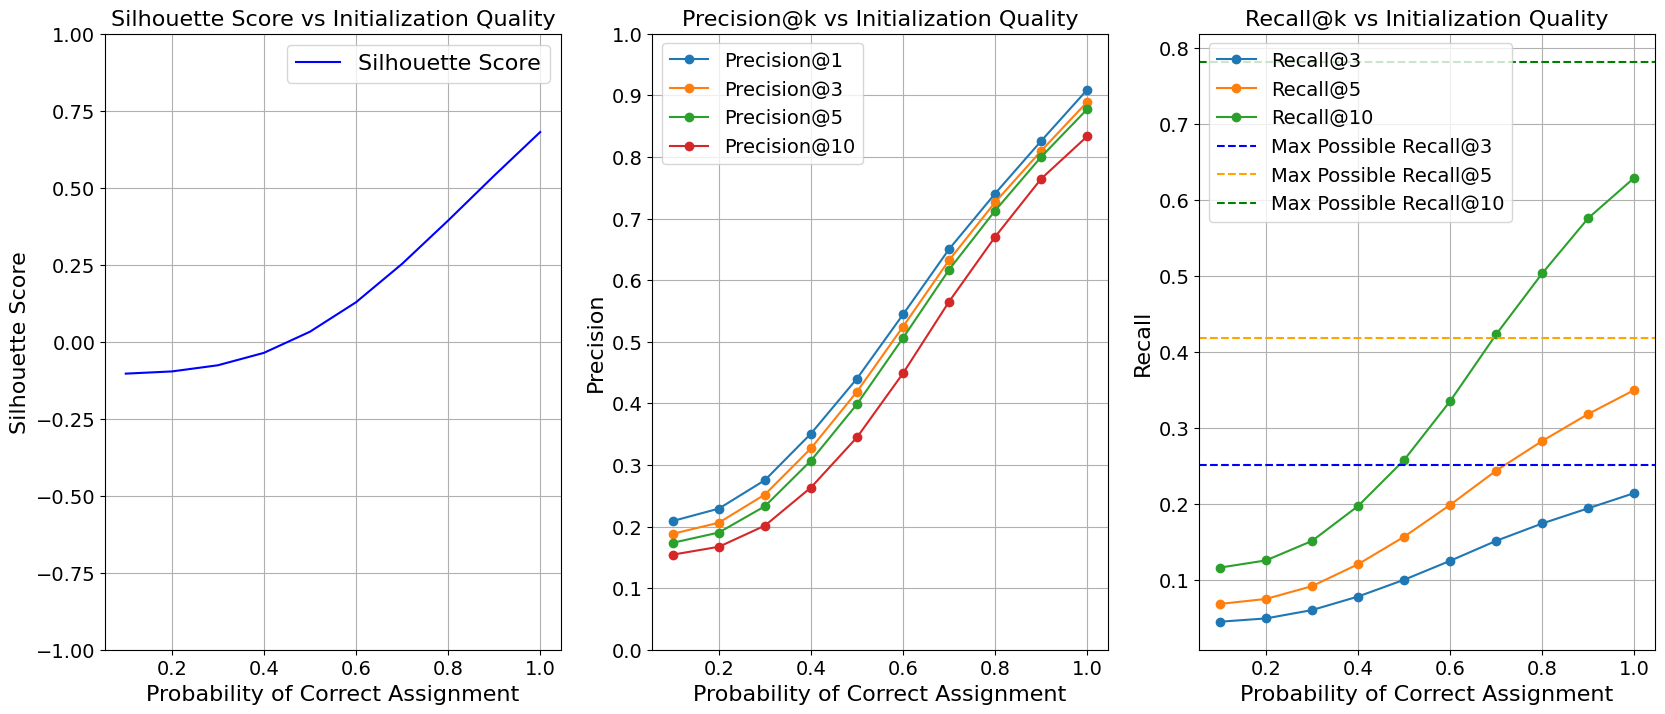

In [ ]:
def get_max_rec_at_k(cat_list, k):
    cat_hist = {}
    for item in cat_list:
        cat_hist[item] = cat_hist.get(item, 0) + 1
    cat_vals = set(cat_list)
    rec_d = {cat: [] for cat in cat_vals}
    for i, _ in enumerate(cat_list):
        correct_cat = cat_list[i]
        rec_d[correct_cat].append(min(k, cat_hist[correct_cat]) / cat_hist[correct_cat])
    rec_at_k = {cat: np.mean(rec_d[cat]) for cat in cat_vals}
    return np.mean(list(rec_at_k.values()))


import pickle


# Plotting (same as original)
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

ax[0].plot(p_vals, sils, label='Silhouette Score', color='blue')
# ax[0].axhline(y=e5_abs_sil, color='r', linestyle='--', label='E5 Abstract Silhouette Score')
# ax[0].axhline(y=e5_mean_sil, color='g', linestyle='--', label='E5 Mean Silhouette Score')
# ax[0].axhline(y=e5_LLM_sil, color='m', linestyle='--', label='E5 LLM Silhouette Score')
ax[0].legend(fontsize=16)
ax[0].set_xlabel('Probability of Correct Assignment', fontsize=16)
ax[0].set_ylabel('Silhouette Score', fontsize=16)
ax[0].set_title('Silhouette Score vs Initialization Quality', fontsize=16)
ax[0].grid(True)
ax[0].set_ylim(-1, 1)

for k in prec_at_k_d.keys():
    ax[1].plot(p_vals, prec_at_k_d[k], label=f'Precision@{k}', marker='o')
    # ax[1].axhline(y=get_recall_at_k(e5_abs_rep, test_set['correct_cat_idx'].tolist(), k), color='r', linestyle='--', label=f'E5 Abstract Recall@{k}')
    # ax[1].axhline(y=get_recall_at_k(e5_mean_rep, test_set['correct_cat_idx'].tolist(), k), color='g', linestyle='--', label=f'E5 Mean Recall@{k}')
    # ax[1].axhline(y=get_recall_at_k(e5_LLM_rep, test_set['correct_cat_idx'].tolist(), k), color='m', linestyle='--', label=f'E5 LLM Recall@{k}')
ax[1].set_xlabel('Probability of Correct Assignment', fontsize=16)
ax[1].set_ylabel('Precision', fontsize=16)
ax[1].set_title('Precision@k vs Initialization Quality', fontsize=16)
ax[1].grid(True)
ax[1].legend(prop={'size': 14})
# ax[1].set_ylim(0, 1)
ax[1].set_yticks(np.arange(0, 1.1, 0.1))

max_rec_d = {k: get_max_rec_at_k(test_set['correct_cat_idx'].tolist(), k) for k in [3, 5, 10]}
for k in [3,5,10]:
    ax[2].plot(p_vals, rec_at_k_d[k], label=f'Recall@{k}', marker='o')
    # ax[2].axhline(y=get_recall_at_k(e5_abs_rep, test_set['correct_cat_idx'].tolist(), k), color='r', linestyle='--', label=f'E5 Abstract Recall@{k}')
    # ax[2].axhline(y=get_recall_at_k(e5_mean_rep, test_set['correct_cat_idx'].tolist(), k), color='g', linestyle='--', label=f'E5 Mean Recall@{k}')
    # ax[2].axhline(y=get_recall_at_k(e5_LLM_rep, test_set['correct_cat_idx'].tolist(), k), color='m', linestyle='--', label=f'E5 LLM Recall@{k}')
ax[2].axhline(y=max_rec_d[3], color='blue', linestyle='--', label=f'Max Possible Recall@3')
ax[2].axhline(y=max_rec_d[5], color='orange', linestyle='--', label=f'Max Possible Recall@5')
ax[2].axhline(y=max_rec_d[10], color='green', linestyle='--', label=f'Max Possible Recall@10')
ax[2].set_xlabel('Probability of Correct Assignment', fontsize=16)
ax[2].set_ylabel('Recall', fontsize=16)
ax[2].set_title('Recall@k vs Initialization Quality', fontsize=16)
ax[2].grid(True)
ax[2].legend(prop={'size': 14})
# ax[2].set_ylim(0, 1)
# ax[2].set_yticks(np.arange(0, 1.1, 0.1))
# plt.tight_layout()
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[2].tick_params(axis='both', which='major', labelsize=14)
with open('RES/FIG/SAVE/PATH', 'wb') as f:
    pickle.dump(fig, f)
plt.show()

### TSNE visualization for silhouette improvements

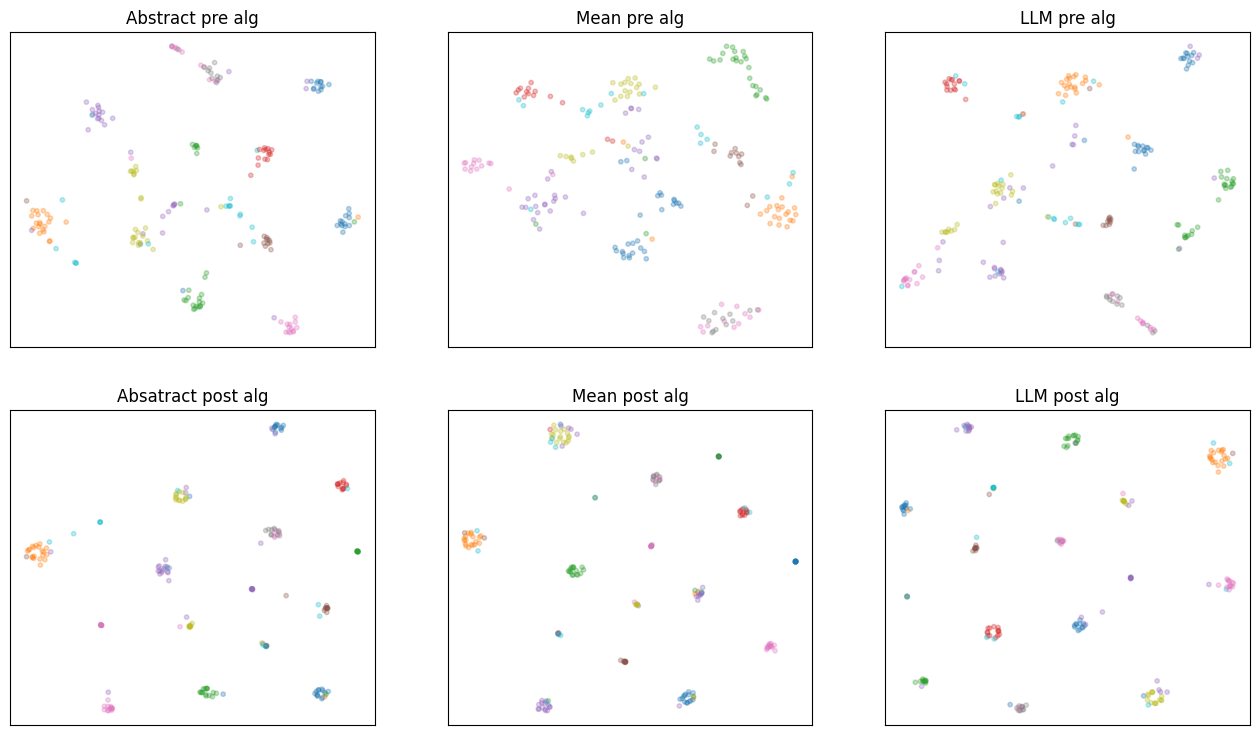

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(16, 9))
from sklearn.manifold import TSNE
categories = test_set['category'].astype(str)
unique_categories = categories.unique()
colors = {cat: i for i, cat in enumerate(unique_categories)}
color_vals = categories.map(colors)
def plot_tsne(ax, data, title):
    tsne = TSNE(n_components=2, random_state=42)
    transformed_data = tsne.fit_transform(data)
    ax.scatter(transformed_data[:, 0], transformed_data[:, 1],
                           c=color_vals, cmap='tab10', alpha=0.3, s=10)
    ax.set_title(title)
    # disable x and y ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
plot_tsne(ax[0, 0], np.array(e5_abs_rep), "Abstract pre alg")
plot_tsne(ax[1, 0], np.array(e5_post_alg_abs_rep), "Absatract post alg")
plot_tsne(ax[0, 1], np.array(e5_mean_rep), "Mean pre alg")
plot_tsne(ax[1, 1], np.array(e5_post_alg_mean_rep), "Mean post alg")
plot_tsne(ax[0, 2], np.array(e5_LLM_rep), "LLM pre alg")
plot_tsne(ax[1, 2], np.array(e5_post_alg_LLM_rep), "LLM post alg")
with open('RES/FIG/SAVE/PATH', 'wb') as f:
    pickle.dump(fig, f)
plt.tight_layout()
plt.show()


### Running selection methods for both models, and extracting F1 values

In [8]:
print('E5')
best_ks_e5 = extract_best_k_for_both_approaches(e5_trained_without_validation, train_set_no_val, val_set,prefix='query: ', ks=ks, model_name='e5')
e5_f1s, e5_sils = best_ks_to_get_final_f1_and_sil(e5_trained_with_validation, full_train_set, test_set, best_ks_e5, prefix='query: ', model_name='e5')
print('MPNET')
best_ks_mpnet = extract_best_k_for_both_approaches(mpnet_trained_without_validation, train_set_no_val, val_set,prefix='', ks=ks, model_name='mpnet')
mpnet_f1s, mpnet_sils = best_ks_to_get_final_f1_and_sil(mpnet_trained_with_validation, full_train_set, test_set, best_ks_mpnet, prefix='', model_name='mpnet')

E5
Centroids shape: (16, 768)


  5%|▌         | 5/100 [00:01<00:35,  2.69it/s]


Centroids shape: (16, 768)


100%|██████████| 19/19 [00:14<00:00,  1.29it/s]


Best k for highest confidence: 5, F1: 0.6810571855497003
Best k for highest certainty: 6, F1: 0.690072031694668
Best k for first: 15, F1: 0.6313900257518145
Centroids shape: (16, 768)


  6%|▌         | 6/100 [00:02<00:37,  2.47it/s]


Centroids shape: (16, 768)
Running selection mode: highest_confidence with k=5


  2%|▏         | 2/100 [00:00<00:12,  7.60it/s]


Converged after 2 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [28.14242473007841, 28.410843495482244, 28.41122430820997]
Running selection mode: highest_certainty with k=6


  3%|▎         | 3/100 [00:00<00:07, 12.21it/s]


Converged after 3 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [30.742683130608413, 31.01015429454753, 31.021399509426125, 31.02326087941551]
Running selection mode: first with k=15


  5%|▌         | 5/100 [00:00<00:10,  9.38it/s]


Converged after 5 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [24.705638197801587, 24.85291884416905, 24.87794114063904, 24.887252732307722, 24.88266436158886, 24.87485547711242]
MPNET
Centroids shape: (16, 768)


  4%|▍         | 4/100 [00:01<00:37,  2.58it/s]


Centroids shape: (16, 768)


100%|██████████| 19/19 [00:14<00:00,  1.30it/s]


Best k for highest confidence: 4, F1: 0.6962072498449723
Best k for highest certainty: 5, F1: 0.6589153272389778
Best k for first: 3, F1: 0.6961136615193237
Centroids shape: (16, 768)


  8%|▊         | 8/100 [00:03<00:35,  2.59it/s]


Centroids shape: (16, 768)
Running selection mode: highest_confidence with k=4


  3%|▎         | 3/100 [00:00<00:11,  8.49it/s]


Converged after 3 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [31.19378176585589, 31.469683232325973, 31.492468073036918, 31.535534405726104]
Running selection mode: highest_certainty with k=5


  3%|▎         | 3/100 [00:00<00:11,  8.49it/s]


Converged after 3 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [27.698944136345414, 27.88402619298951, 27.91208570897559, 27.948859049884813]
Running selection mode: first with k=3


  2%|▏         | 2/100 [00:00<00:13,  7.52it/s]

Converged after 2 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [27.386819773838337, 27.738176469077175, 27.714244311885064]


### Mean aggregation prediction

In [9]:
par_e5_col = 'pars_e5_embedding'
par_mpnet_col = 'pars_mpnet_embedding'

abstract_e5_col = 'abstract_e5_embedding'
abstract_mpnet_col = 'abstract_mpnet_embedding'

cat_d = {cat:i for i, cat in enumerate(test_set['category'].unique())}
test_set['mean_e5_embedding'] = test_set[par_e5_col].apply(lambda x: np.mean(x,axis=0))
test_set['mean_mpnet_embedding'] = test_set[par_mpnet_col].apply(lambda x: np.mean(x,axis=0))
e5_sils['mean of all'] = silhouette_score(np.array(test_set['mean_e5_embedding'].tolist()), test_set['category'].apply(lambda x: cat_d[x]).tolist(), metric='cosine')
mpnet_sils['mean of all'] = silhouette_score(np.array(test_set['mean_mpnet_embedding'].tolist()), test_set['category'].apply(lambda x: cat_d[x]).tolist(), metric='cosine')

e5_cents, e5_cent_d = train_df_to_centroids_v2(full_train_set, abstract_e5_col)
mpnet_cents, mpnet_cent_d = train_df_to_centroids_v2(full_train_set, abstract_mpnet_col)

e5_train = alg_for_par_selection(full_train_set, e5_cents, abstract_e5_col, par_e5_col)
mpnet_train = alg_for_par_selection(full_train_set, mpnet_cents, abstract_mpnet_col, par_mpnet_col)

post_alg_e5_cents, post_alg_e5_cent_d = train_df_to_centroids_v2(e5_train, 'closest_par')
post_alg_mpnet_cents, post_alg_mpnet_cent_d = train_df_to_centroids_v2(mpnet_train, 'closest_par')

test_set['e5_pred'] = test_set['mean_e5_embedding'].apply(lambda x: np.argmax(cosine_similarity([x], post_alg_e5_cents)[0]))

test_set['mpnet_pred'] = test_set['mean_mpnet_embedding'].apply(lambda x: np.argmax(cosine_similarity([x], post_alg_mpnet_cents)[0]))


e5_pairs = pd.merge(test_set[['id','category', 'e5_pred']],
                    test_set[['id','category', 'e5_pred']],
                    how='cross', suffixes=('_1', '_2'))
e5_pairs['label'] = e5_pairs.apply(lambda x: 1 if x['category_1'] == x['category_2'] else 0, axis=1)
e5_pairs['pred'] = e5_pairs.apply(lambda x: 1 if x['e5_pred_1'] == x['e5_pred_2'] else 0, axis=1)
e5_f1s['mean of all'] = get_macro_f1(e5_pairs)[0]
mpnet_pairs = pd.merge(test_set[['id','category', 'mpnet_pred']],
                       test_set[['id','category', 'mpnet_pred']],
                       how='cross', suffixes=('_1', '_2'))
mpnet_pairs['label'] = mpnet_pairs.apply(lambda x: 1 if x['category_1'] == x['category_2'] else 0, axis=1)
mpnet_pairs['pred'] = mpnet_pairs.apply(lambda x: 1 if x['mpnet_pred_1'] == x['mpnet_pred_2'] else 0, axis=1)
mpnet_f1s['mean of all'] = get_macro_f1(mpnet_pairs)[0]

Centroids shape: (16, 768)
Centroids shape: (16, 768)


  6%|▌         | 6/100 [00:02<00:38,  2.46it/s]

Converged after 6 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [0.9421602, 0.94269377, 0.9427497, 0.94276816, 0.94277966, 0.942785, 0.9427865]



  8%|▊         | 8/100 [00:03<00:35,  2.60it/s]

Converged after 8 iterations due to no change in closest paragraphs
Silhouette scores during iterations
 [0.9439055, 0.94448924, 0.9445731, 0.944603, 0.94461834, 0.9446306, 0.94463694, 0.9446395, 0.9446404]
Centroids shape: (16, 768)
Centroids shape: (16, 768)


### Validation for hyper parameter extraction

In [10]:
print(best_ks_mpnet)
print(best_ks_e5)


{'highest_confidence': 4, 'highest_certainty': 5, 'first': 3}
{'highest_confidence': 5, 'highest_certainty': 6, 'first': 15}


### Final result tables

In [11]:
pd.DataFrame([mpnet_f1s, e5_f1s], index=['mpnet', 'e5']).T.to_csv('f1s_mpnet_e5_comparison_sci_papers.csv')
pd.DataFrame([mpnet_f1s, e5_f1s], index=['mpnet', 'e5']).T

,mpnet,e5
LLM summary,0.578277,0.555031
abstract,0.534670,0.551506
highest_confidence,0.631844,0.591926
highest_certainty,0.598839,0.601898
first,0.606599,0.545353
mean of all,0.549924,0.495385


In [12]:
pd.DataFrame([mpnet_sils, e5_sils], index=['mpnet', 'e5']).T.to_csv('sils_mpnet_e5_comparison_sci_papers.csv')
pd.DataFrame([mpnet_sils, e5_sils], index=['mpnet', 'e5']).T



,mpnet,e5
abstract representation,0.448524,0.4552
LLM summary representation,0.464613,0.435288
random highest_confidence,0.4+- 0.017,0.336+- 0.017
highest_confidence alg selection,0.549389,0.492572
random highest_certainty,0.372+- 0.017,0.357+- 0.017
highest_certainty alg selection,0.511692,0.52381
random first,0.383+- 0.017,0.311+- 0.016
first alg selection,0.52469,0.441674
mean of all,0.409436,0.365019
